<a href="https://colab.research.google.com/github/princessivy/Analyzing_CSGO_SkinPrices/blob/main/CSGO_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
from pathlib import Path

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

# Daten einlesen

In [2]:
data = pd.read_csv(r'/content/drive/MyDrive/SA_BA/Data/allitems_ready_for_model.csv')

In [79]:
data

,salePrice,salePricelog,suggestedPrice,ext_Battle-Scarred,ext_Factory New,ext_Field-Tested,ext_Minimal Wear,ext_Well-Worn,rar_Classified,rar_Covert,...,col_The Wildfire Collection,col_The Winter Offensive Collection,col_The X-Ray Collection,col_The eSports 2014 Summer Collection,lock,wear,stickers,souvenir,stattrak,colorfulness
0,399.13,5.989287,397.21,0,1,0,0,0,0,1,...,0,0,0,0,0,0.033243,0,0,0,59.790243
1,362.44,5.892859,442.03,0,1,0,0,0,0,1,...,0,0,0,0,1,0.025035,0,0,1,57.181995
2,400.00,5.991465,397.21,0,1,0,0,0,0,1,...,0,0,0,0,0,0.006977,0,0,0,58.160273
3,420.73,6.041991,397.21,0,1,0,0,0,0,1,...,0,0,0,0,0,0.006662,0,0,0,58.489647
4,355.00,5.872118,397.21,0,1,0,0,0,0,1,...,0,0,0,0,1,0.062841,0,0,0,60.797777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27455,71.84,4.274441,70.72,0,0,1,0,0,0,0,...,0,0,0,0,1,0.293997,0,0,0,10.935599
27456,73.42,4.296196,70.72,0,0,1,0,0,0,0,...,0,0,0,0,1,0.185491,0,0,0,10.850061
27457,75.00,4.317488,70.72,0,0,1,0,0,0,0,...,0,0,0,0,1,0.169524,0,0,0,10.913781
27458,75.00,4.317488,70.72,0,0,1,0,0,0,0,...,0,0,0,0,1,0.160716,0,0,0,10.794303


In [3]:
data['suggestedPricelog'] = np.log(data['suggestedPrice'])

# Modell

## Splits

In [4]:
y = data['salePrice']
X = data.drop(['salePrice', 'salePricelog'], 1)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [5]:
# suggestedPricelog sichern
train_X_sugPr = train_X.copy()
val_X_sugPr = val_X.copy()

In [6]:
# suggestedPricelog aus normalen Daten löschen
train_X = train_X.drop(['suggestedPricelog', 'suggestedPrice'], 1)
val_X = val_X.drop(['suggestedPricelog', 'suggestedPrice'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
print(train_X.shape)
print(val_X.shape)

(20595, 530)
(6865, 530)


## Modell

#### Bester Wert ohne Hyperparametertuning mit Tweedie-Regression

In [221]:
xg_reg = xgb.XGBRegressor(objective = 'reg:tweedie', booster='gblinear', eval_metric='tweedie-nloglik@1.2',tweedie_variance_power=1.1, random_state=42)

In [93]:
scaler = StandardScaler()

In [94]:
train_X_standardized = pd.DataFrame(scaler.fit_transform(train_X), columns=train_X.columns, index=train_X.index)
val_X_standardized = pd.DataFrame(scaler.transform(val_X), columns=train_X.columns, index=val_X.index)

In [222]:
xg_reg.fit(train_X_standardized, train_y)

XGBRegressor(booster='gblinear', eval_metric='tweedie-nloglik@1.2',
             objective='reg:tweedie', random_state=42,
             tweedie_variance_power=1.1)

In [223]:
preds = xg_reg.predict(val_X_standardized)

In [224]:
# in EUR
mean_absolute_error(val_y, preds)

53.266328239625764

In [207]:
# Score = R2-Wert
score = xg_reg.score(val_X_standardized, val_y)
score

0.7347161859156056

In [59]:
# Wert des Modells von SkinPort zum Vergleich in EUR
mean_absolute_error(val_y, val_X_sugPr['suggestedPrice'])

37.41654916241806

#### Bester Gesamtwert mit Hyperparametertuning mittels Tree Booster

In [8]:
# bestes Modell:
xg_reg_tree = xgb.XGBRegressor(colsample_bytree=0.4, eval_metric='mae', gamma=0.0, max_depth=10, n_estimators=1100, objective='reg:squarederror', random_state=42, scale_pos_weight=50)

In [9]:
scaler = StandardScaler()

In [10]:
train_X_standardized = pd.DataFrame(scaler.fit_transform(train_X), columns=train_X.columns, index=train_X.index)
val_X_standardized = pd.DataFrame(scaler.transform(val_X), columns=train_X.columns, index=val_X.index)

In [11]:
xg_reg_tree.fit(train_X_standardized, train_y)

XGBRegressor(colsample_bytree=0.4, eval_metric='mae', gamma=0.0, max_depth=10,
             n_estimators=1100, objective='reg:squarederror', random_state=42,
             scale_pos_weight=50)

In [12]:
preds = xg_reg_tree.predict(val_X_standardized)

In [13]:
# in EUR
mean_absolute_error(val_y, preds)

50.8626326763972

In [15]:
# Score = R2-Wert
score = xg_reg_tree.score(val_X_standardized, val_y)
score

0.6801905060554903

In [232]:
# Wert des Modells von SkinPort zum Vergleich in EUR
mean_absolute_error(val_y, val_X_sugPr['suggestedPrice'])

37.41654916241806

In [238]:
hyper_grid = {
    'booster': ['gbtree', 'gblinear'],
    'n_estimators': [100, 500, 900, 1100, 1500],
    'learning_rate' : [0.05, 0.1, 0.2, 0.4, 0.6],
    'gamma' : [0.0, 0.1, 0.2, 0.4, 0.7],
    'max_depth': [2, 5, 7, 10],
    'min_child_weight': [1, 3, 5, 8],
    'colsample_bytree':[0.4, 0.5, 0.7, 0.8],
    'scale_pos_weight':[1, 30, 50, 80, 90, 100]
}

In [239]:
random_cv = RandomizedSearchCV(estimator=xg_reg_tree,
            param_distributions=hyper_grid,
            cv=5, n_iter=10,
            scoring = 'neg_mean_absolute_error',n_jobs = -1,
            verbose = 3, 
            return_train_score = True,
            random_state=42)

In [240]:
random_cv.fit(train_X_standardized, train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(eval_metric='mae',
                                          objective='reg:squarederror',
                                          random_state=42),
                   n_jobs=-1,
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'colsample_bytree': [0.4, 0.5, 0.7,
                                                             0.8],
                                        'gamma': [0.0, 0.1, 0.2, 0.4, 0.7],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.4,
                                                          0.6],
                                        'max_depth': [2, 5, 7, 10],
                                        'min_child_weight': [1, 3, 5, 8],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500],
                               

In [241]:
random_cv.best_estimator_

XGBRegressor(colsample_bytree=0.4, eval_metric='mae', gamma=0.0, max_depth=10,
             n_estimators=1100, objective='reg:squarederror', random_state=42,
             scale_pos_weight=50)

In [242]:
random_cv.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.4,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 1100,
 'scale_pos_weight': 50}

# Ergebnisse mit unterschiedlichen XGB-Parametern:
* xgb.XGBRegressor(objective = 'reg:squarederror', booster='gblinear', reg_lambda=1, updater='coord_descent', random_state=42)
  * MAE: 101,72
* xgb.XGBRegressor(objective = 'reg:squarederror', booster='gbtree', random_state=42)
  * MAE: 104,70
* xgb.XGBRegressor(objective = 'reg:gamma', booster='gblinear', random_state=42)
  * MAE: 88,79
* xgb.XGBRegressor(objective = 'reg:tweedie', booster='gblinear', eval_metric='rmse', random_state=42)
  * MAE: 56,44
* xgb.XGBRegressor(objective = 'reg:tweedie', booster='gblinear', eval_metric='mae', random_state=42)
  * MAE: 56,44
* xgb.XGBRegressor(objective = 'reg:tweedie', booster='gblinear', eval_metric='tweedie-nloglik@1.2', random_state=42)
  * MAE: 56,44
* xgb.XGBRegressor(objective = 'reg:tweedie', booster='gblinear', eval_metric='tweedie-nloglik@1.2',tweedie_variance_power=1.4, random_state=42)
  * MAE:70,06
* xgb.XGBRegressor(objective = 'reg:tweedie', booster='gblinear', eval_metric='tweedie-nloglik@1.2',tweedie_variance_power=1.4, random_state=42)
  * MAE: 55,02
* xgb.XGBRegressor(objective = 'reg:tweedie', booster='gblinear', eval_metric='tweedie-nloglik@1.2',tweedie_variance_power=1.3, random_state=42)
  * MAE: 53,95
* xgb.XGBRegressor(objective = 'reg:tweedie', booster='gblinear', eval_metric='tweedie-nloglik@1.2',tweedie_variance_power=1.1, random_state=42)
  * MAE: 53,27

**Mit Hyperparametertuning:**
* xgb.XGBRegressor(colsample_bytree=0.4, eval_metric='mae', gamma=0.0, max_depth=10, n_estimators=1100, objective='reg:squarederror', random_state=42, scale_pos_weight=50)
  * MAE: 50,86

# Ausgelagert: SHAP mit bestem Modell (Tree Booster) - nur für mich (bitte ignorieren)

In [17]:
!pip install shap --quiet

     |████████████████████████████████| 564 kB 3.9 MB/s 


In [18]:
import shap

In [21]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(xg_reg_tree)
shap_values = explainer(train_X_standardized, check_additivity=False)

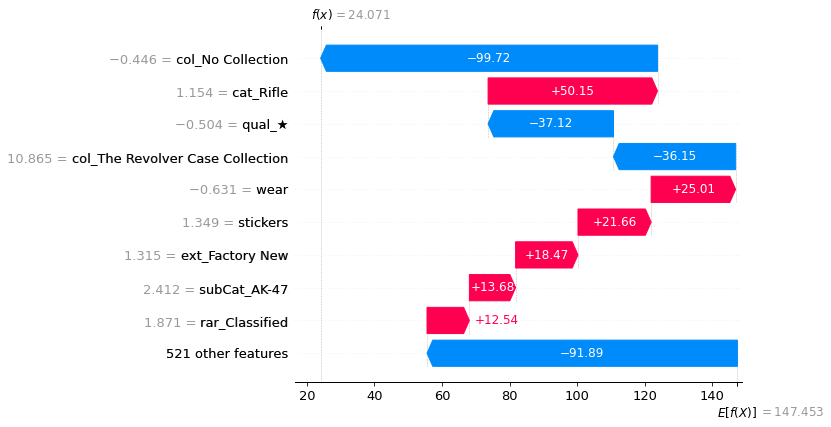

In [22]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [23]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

In [ ]:
# visualize all the training set predictions
shap.plots.force(shap_values)

shap.plots.force is slow for many thousands of rows, try subsampling your data.


In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.bar(shap_values)